
# Alternative Linear Solvers (Scipy and Petsc)
Here we look at different ways of solving PDEs using external
packages and python functionality.
Different linear algebra backends can be accessed by changing setting the
`storage` parameter during construction of the discrete space. All
discrete functions and operators/schemes based on this space will then
use this backend. Available backends are `numpy,istl,petsc`. The default is
`numpy` which uses simple data structures and linear solvers implemented in
the `dune-fem` package. The simplicity of the data structure makes it
possible to use the buffer protocol to seamlessly move between C++ and
Numpy/Scipy data structures on the python side. A degrees of freedom
vector (dof vector) can be retrieved from a discrete function over the
`numpy` space by using the `as_numpy` method. Similar methods are available
for the other storages, i.e., `as_istl,as_petsc`. The same methods are
also available to retrieve the underlying matrix structures of linear
operators.

We will revisit the nonlinear time dependent problem studied in the
introduction which after discretizing in time had the variational formulation
\begin{equation}
\begin{split}
\int_{\Omega} \frac{u^{n+1}-u^n}{\Delta t} \varphi
+ \frac{1}{2}K(\nabla u^{n+1}) \nabla u^{n+1} \cdot \nabla \varphi \
+ \frac{1}{2}K(\nabla u^n) \nabla u^n \cdot \nabla \varphi v\ dx \\
- \int_{\Omega} \frac{1}{2}(f(x,t^n)+f(x,t^n+\Delta t) \varphi\ dx
- \int_{\partial \Omega} \frac{1}{2}(g(x,t^n)+g(x,t^n+\Delta t)) v\ ds
= 0.
\end{split}
\end{equation}
on a domain $\Omega=[0,1]^2$. We choose $f,g$ so that the exact solution
is given by
\begin{align*}
u(x,t) = e^{-2t}\left(\frac{1}{2}(x^2 + y^2) - \frac{1}{3}(x^3 - y^3)\right) + 1
\end{align*}
The following code was described in the introduction:

In [1]:
import numpy, sys, io

from dune.grid import structuredGrid as leafGridView
from dune.fem.space import lagrange as solutionSpace
from dune.fem.scheme import galerkin as solutionScheme
from dune.fem.function import gridFunction, integrate, uflFunction
from dune.ufl import Constant
from ufl import TestFunction, TrialFunction, SpatialCoordinate, FacetNormal, \
                dx, ds, div, grad, dot, inner, sqrt, exp, sin,\
                conditional

gridView = leafGridView([0, 0], [1, 1], [4, 4])
space = solutionSpace(gridView, order=2)

x = SpatialCoordinate(space)
initial = 1/2*(x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1
exact   = lambda t: exp(-2*t)*(initial - 1) + 1

u_h   = space.interpolate(initial, name='u_h')
u_h_n = u_h.copy(name="previous")

u = TrialFunction(space)
v = TestFunction(space)
dt = Constant(0, name="dt")    # time step
t  = Constant(0, name="t")     # current time

abs_du = lambda u: sqrt(inner(grad(u), grad(u)))
K = lambda u: 2/(1 + sqrt(1 + 4*abs_du(u)))
a = ( dot((u - u_h_n)/dt, v) \
    + 0.5*dot(K(u)*grad(u), grad(v)) \
    + 0.5*dot(K(u_h_n)*grad(u_h_n), grad(v)) ) * dx

f = lambda s: -2*exp(-2*s)*(initial - 1) - div( K(exact(s))*grad(exact(s)) )
g = lambda s: K(exact(s))*grad(exact(s))
n = FacetNormal(space)
b = 0.5*(f(t)+f(t+dt))*v*dx + 0.5*dot(g(t)+g(t+dt),n)*v*ds

When creating a scheme, it is possible to set the linear solver as well as
parameters for the internal Newton solver and the linear solver
and preconditioning. See a list of available solvers and preconditioning
methods here.

In [2]:

scheme = solutionScheme(a == b, solver='cg')

endTime    = 0.25
exact_end  = exact(endTime)
l2error = uflFunction(gridView, name="l2error", order=u_h.space.order, ufl=dot(u_h - exact_end, u_h - exact_end))
h1error = uflFunction(gridView, name="h1error", order=u_h.space.order, ufl=dot(grad(u_h - exact_end), grad(u_h - exact_end)))

We define a function to evolve the solution from time 0 to the end time.
The first argument is a class with a `solve` method that moves the
solution from one time level to the next - i.e., solves for $u^{n+1}$
given $u^n$:

In [3]:
def evolve(scheme, u_h, u_h_n, endTime):
    time = 0
    while time < (endTime - 1e-6):
        scheme.model.t = time
        u_h_n.assign(u_h)
        scheme.solve(target=u_h)
        time += scheme.model.dt

We can simply use the `scheme` in this function to produce the solution
at the final time. We combine this with a loop to compute the error over
two grids and estimate the convergence rate:

Forchheimer: step: 0 , size: 16
	 | u_h - u | = 1.30293e-04 , eoc = -
	 | grad(uh - u) | = 3.99906e-03 , eoc = -


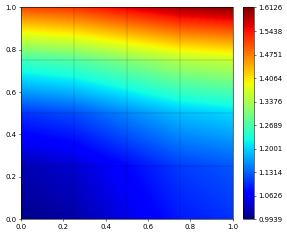

Forchheimer: step: 1 , size: 64
	 | u_h - u | = 1.61439e-05 , eoc = 3.01
	 | grad(uh - u) | = 9.99164e-04 , eoc = 2.0


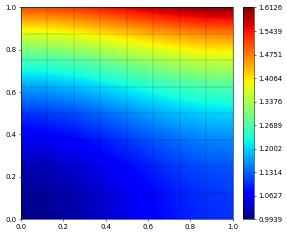

In [4]:
scheme.model.dt = 0.005

errors = 0,0
loops = 2
for eocLoop in range(loops):
    u_h.interpolate(initial)
    evolve(scheme, u_h, u_h_n, endTime)
    errors_old = errors
    errors = [sqrt(e) for e in integrate(gridView, [l2error,h1error], order=5)]
    if eocLoop == 0:
        eocs = ['-','-']
    else:
        eocs = [ round(numpy.log(e/e_old)/numpy.log(0.5),2) \
                 for e,e_old in zip(errors,errors_old) ]
    print('Forchheimer: step:', eocLoop, ', size:', gridView.size(0))
    print('\t | u_h - u | =', '{:0.5e}'.format(errors[0]), ', eoc =', eocs[0])
    print('\t | grad(uh - u) | =', '{:0.5e}'.format(errors[1]), ', eoc =', eocs[1])
    u_h.plot()
    if eocLoop < loops-1:
        gridView.hierarchicalGrid.globalRefine(1)
        scheme.model.dt /= 2

.. index::
   pair: Solvers; Scipy

## Using Scipy
We implement a simple Newton Krylov solver using a linear solver from
Scipy. We can use the `as_numpy` method to access the degrees of freedom as
Numpy vector based on the `python buffer protocol`. So no data is copied
and changes to the dofs made on the python side are automatically carried
over to the C++ side.
from Scipy.

In [5]:
from dune.fem.operator import linear as linearOperator
import numpy as np
from scipy.sparse.linalg import spsolve as solver
class Scheme:
  def __init__(self, scheme):
      self.model = scheme.model
      self.jacobian = linearOperator(scheme)

  def solve(self, target):
      # create a copy of target for the residual
      res = target.copy(name="residual")

      # extract numpy vectors from target and res
      sol_coeff = target.as_numpy
      res_coeff = res.as_numpy

      n = 0
      while True:
          scheme(target, res)
          absF = numpy.sqrt( np.dot(res_coeff,res_coeff) )
          if absF < 1e-10:
              break
          scheme.jacobian(target,self.jacobian)
          sol_coeff -= solver(self.jacobian.as_numpy, res_coeff)
          n += 1

scheme_cls = Scheme(scheme)

u_h.interpolate(initial)                # reset u_h to initial
evolve(scheme_cls, u_h, u_h_n, endTime)
error = u_h - exact_end
print("Forchheimer(numpy) size: ", gridView.size(0), "L^2, H^1 error:",'{:0.5e}, {:0.5e}'.format(
  *[ sqrt(e) for e in integrate(gridView,[error**2,inner(grad(error),grad(error))], order=5) ]))

Forchheimer(numpy) size:  64 L^2, H^1 error: 1.61699e-05, 9.99162e-04


Using a non linear solver from the Scipy package

In [6]:
from scipy.optimize import newton_krylov
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import cg as solver

class Scheme2:
    def __init__(self, scheme):
        self.scheme = scheme
        self.model = scheme.model
        self.res = u_h.copy(name="residual")

    # non linear function
    def f(self, x_coeff):
        # the following converts a given numpy array
        # into a discrete function over the given space
        x = space.function("tmp", dofVector=x_coeff)
        scheme(x, self.res)
        return self.res.as_numpy

    # class for the derivative DS of S
    class Df(LinearOperator):
        def __init__(self, x_coeff):
            self.shape = (x_coeff.shape[0], x_coeff.shape[0])
            self.dtype = x_coeff.dtype
            x = space.function("tmp", dofVector=x_coeff)
            self.jacobian = linearOperator(scheme, ubar=x)
        # reassemble the matrix DF(u) given a DoF vector for u
        def update(self, x_coeff, f):
            x = space.function("tmp", dofVector=x_coeff)
            scheme.jacobian(x, self.jacobian)
        # compute DS(u)^{-1}x for a given DoF vector x
        def _matvec(self, x_coeff):
            return solver(self.jacobian.as_numpy, x_coeff, tol=1e-10)[0]

    def solve(self, target):
        sol_coeff = target.as_numpy
        # call the newton krylov solver from scipy
        sol_coeff[:] = newton_krylov(self.f, sol_coeff,
                    verbose=0, f_tol=1e-8,
                    inner_M=self.Df(sol_coeff))

scheme2_cls = Scheme2(scheme)
u_h.interpolate(initial)
evolve(scheme2_cls, u_h, u_h_n, endTime)
error = u_h - exact_end
print("Forchheimer(scipy) size: ", gridView.size(0), "L^2, H^1 error:",'{:0.5e}, {:0.5e}'.format(
  *[ sqrt(e) for e in integrate(gridView,[error**2,inner(grad(error),grad(error))], order=5) ]))

Forchheimer(scipy) size:  64 L^2, H^1 error: 1.61699e-05, 9.99162e-04


.. index::
   triple: Solvers; Dirichlet; Conditions

.. index::
   pair: Boundary; Linear Solvers

## Handling Dirichlet boundary conditions
We look at a simple Poisson problem with Dirichlet BCs
to show how to use external solvers like the cg method
from Scipy in this case.
We solve $-\triangle u=10\chi_\omega$ where $\chi_\omega$ is a characteristic
function with $\omega=\{x\colon |x|^2<0.6\}$. For the boundary
we prescribe trivial Neuman at the top and bottom boundaries
and Dirichlet values $u=-1$ and $u=1$ at the left and right
boundaries, respectively.
We will use the CG solver from `scipy.sparse.linalg`:

Note: since we are not needing to invert the operator
we will use the `dune.fem.operator.galerkin` class
to setup the problem. This is similar to `dune.fem.scheme.galerkin`
we have been using so far but can be used to model
operators between different spaces.

In [7]:
from dune.ufl import DirichletBC
from dune.fem.operator import galerkin
from scipy.sparse.linalg import cg as solver
model  = ( inner(grad(u), grad(v)) -
           conditional(dot(x,x)<0.6,10.,0.) * v ) * dx
dbcs   = [ DirichletBC(space,-1,1),
           DirichletBC(space, 1,2) ]
op     = galerkin([model, *dbcs], space)
A = linearOperator(op).as_numpy
sol = space.interpolate(0, name="u_h")
rhs = sol.copy()
op(sol, rhs)
rhs.as_numpy[:] *= -1

So far everything is as before. Dirichlet boundary conditions
are handled in the matrix through changing all rows
associated with boundary degrees of freedom to unit rows -
associated columns are not changed so the matrix will not be symmetric anymore.
For solving the system we need to modify the right hand side
and the initial guess for the iterative solver to include
the boundary values (to counter the missing symmetry).
We can use the first of the three versions of the
`setConstraints` methods on the scheme class discussed
[previously](boundary_nb.ipynb#Accessing-the-Dirichlet-degrees-of-freedom).

21.55296640308153	

6.325538337303646	

4.9538326818945055	

2.5173844235759577	

2.539915020910759	

1.255638332606404	

1.556921896084911	

1.2786201081471538	

0.9125357940577172	

0.3567921408073923	

0.25994758394167156	

0.14086624759863342	

0.15758393220869005	

0.21043641476997893	

0.22098421334000376	

0.36115057029326086	

0.22948222295623313	

0.08966742907848002	

0.06571321824701298	

0.027183843287078607	

0.009725308020726258	

0.008752431767516318	

0.007409479346256056	

0.012270132675777336	

0.0059332308589065	

0.002224806567715096	

0.0035704612293147235	

0.00490537677249173

0.0031044040102589385	

0.0018845766417821147	

0.00042391511594888046	

0.00019993006312544654	

8.035559607737813e-05	

3.939121668645701e-05	

5.349842175523707e-05	

3.8926838321981366e-05	

1.0753629248123844e-05	

5.1974427087819875e-06	

3.3158088528764237e-06	

3.4676669782111345e-06	

1.94968281493468e-06	

7.432979169337928e-07	

3.2758055946926614e-07	

1.1513640568605316e-07	

7.510339459497494e-08	

3.8300904178002884e-08	

1.3063486035075482e-08	

5.799521579499239e-09	

2.3524139710889802e-09	

1.1619915791928467e-09	

6.286508015665321e-10	

1.5449859640060734e-10	

5.350843039288748e-11	

4.571537744068508e-11	

1.840069336063139e-11	

1.0276595189657079e-11	

5.3287341214728974e-12	

4.313640881038006e-12	

3.3080552070935544e-12	

8.007039260903458e-13	

4.816491324135488e-13	

5.265750544452217e-13	

3.8623256093587853e-13	

1.6186073220632206e-13	

6.662699889653917e-14	

2.376657644983764e-14	

1.1203094950802863e-14	

3.7512718356341775e-15	

1.1597688902969696e-15	

4.253765982456133e-16	

1.1300178566146777e-16	

4.413968841233794e-17	

6.481396701039757e-18	

2.443664915752891e-18	

8.767390492059795e-19	

5.894900350554604e-19	

1.3827319406128333e-19	

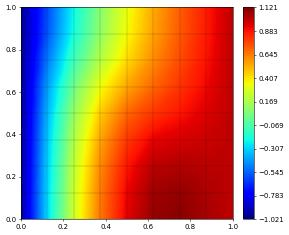

In [8]:
op.setConstraints(rhs)
op.setConstraints(sol)
rk = sol.copy("residual")
def cb(xk): # a callback to print the residual norm in each step
    x_h = space.function("iterate", dofVector=xk)
    op(x_h,rk)
    print(rk.as_numpy[:].dot(rk.as_numpy[:]), flush=True, end='\t')
sol.as_numpy[:], _ = solver(A, rhs.as_numpy, x0=sol.as_numpy,
                            callback=cb, tol=1e-10)
sol.plot()

.. index::
   pair: Solvers; Petsc

## Using Petsc and Petsc4Py
Switching to a storage based on the PETSc solver package and solving the
system using the dune-fem bindings

In [9]:
from dune.generator import ConfigurationError
try:
    import petsc4py
    petsc4py.init(sys.argv)
    from petsc4py import PETSc
    spacePetsc = solutionSpace(gridView, order=2, storage='petsc')
except ModuleNotFoundError:
    print("petsc4py not found: skipping example")
    print("petsc4py module not found so skipping example - ignored")
    petsc4py = None
except ConfigurationError:
    print("petsc4py found but petsc was not found during configuration of dune")
    petsc4py = None
    pass

if petsc4py is not None:
    # first we will use the petsc solver available in the `dune-fem` package
    # (using the sor preconditioner)
    schemePetsc = solutionScheme(a == b, space=spacePetsc,
                    parameters={"linear.preconditioning.method":"sor"})
    schemePetsc.model.dt = scheme.model.dt
    u_h = spacePetsc.interpolate(initial, name='u_h')
    u_h_n = u_h.copy(name="previous")
    evolve(schemePetsc, u_h, u_h_n, endTime)
    error = u_h - exact_end
    print("Forchheimer(petsc) size: ", gridView.size(0), "L^2, H^1 error:",'{:0.5e}, {:0.5e}'.format(
      *[ sqrt(e) for e in integrate(gridView,[error**2,inner(grad(error),grad(error))], order=5) ]))
else:
    print("petsc module not found so skipping example - ignored")
    spacePetsc = None
    pass

petsc4py not found: skipping example
petsc4py module not found so skipping example - ignored
petsc module not found so skipping example - ignored


Implementing a Newton Krylov solver using the binding provided by petsc4py

In [10]:
if petsc4py is not None and spacePetsc is not None:
    class Scheme3:
      def __init__(self, scheme):
          self.model = scheme.model
          self.jacobian = linearOperator(scheme)
          self.ksp = PETSc.KSP()
          self.ksp.create(PETSc.COMM_WORLD)
          # use conjugate gradients method
          self.ksp.setType("cg")
          # and incomplete Cholesky
          self.ksp.getPC().setType("icc")
          self.ksp.setOperators(self.jacobian.as_petsc)
          self.ksp.setFromOptions()
      def solve(self, target):
          res = target.copy(name="residual")
          sol_coeff = target.as_petsc
          res_coeff = res.as_petsc
          n = 0
          while True:
              schemePetsc(target, res)
              absF = numpy.sqrt( res_coeff.dot(res_coeff) )
              if absF < 1e-10:
                  break
              schemePetsc.jacobian(target, self.jacobian)
              self.ksp.solve(res_coeff, res_coeff)
              sol_coeff -= res_coeff
              n += 1

    u_h.interpolate(initial)
    scheme3_cls = Scheme3(schemePetsc)
    evolve(scheme3_cls, u_h, u_h_n, endTime)
    error = u_h - exact_end
    print("Forchheimer(petsc) size: ", gridView.size(0), "L^2, H^1 error:",'{:0.5e}, {:0.5e}'.format(
      *[ sqrt(e) for e in integrate(gridView,[error**2,inner(grad(error),grad(error))], order=5) ]))

Using the petsc4py bindings for the non linear KSP solvers from PETSc

In [11]:
if petsc4py is not None and spacePetsc is not None:
    class Scheme4:
        def __init__(self, scheme):
            self.model = scheme.model
            self.res = scheme.space.interpolate([0],name="residual")
            self.scheme = scheme
            self.jacobian = linearOperator(self.scheme)
            self.snes = PETSc.SNES().create()
            self.snes.setFunction(self.f, self.res.as_petsc.duplicate())
            self.snes.setUseMF(False)
            self.snes.setJacobian(self.Df, self.jacobian.as_petsc, self.jacobian.as_petsc)
            self.snes.getKSP().setType("cg")
            self.snes.setFromOptions()

        def f(self, snes, x, f):
            # setup discrete function using the provide petsc vectors
            inDF = self.scheme.space.function("tmp",dofVector=x)
            outDF = self.scheme.space.function("tmp",dofVector=f)
            self.scheme(inDF,outDF)

        def Df(self, snes, x, m, b):
            inDF = self.scheme.space.function("tmp",dofVector=x)
            self.scheme.jacobian(inDF, self.jacobian)
            return PETSc.Mat.Structure.SAME_NONZERO_PATTERN

        def solve(self, target):
            sol_coeff = target.as_petsc
            self.res.clear()
            self.snes.solve(self.res.as_petsc, sol_coeff)

    u_h.interpolate(initial)
    scheme4_cls = Scheme4(schemePetsc)
    evolve(scheme4_cls, u_h, u_h_n, endTime)
    error = u_h - exact_end
    print("Forchheimer(petsc4py) size: ", gridView.size(0), "L^2, H^1 error:",'{:0.5e}, {:0.5e}'.format(
      *[ sqrt(e) for e in integrate(gridView,[error**2,inner(grad(error),grad(error))], order=5) ]))

.. index::
   triple: I/O; Logging; Parameters

## Accessing and reusing values of parameters
Sometimes it is necessary to extract which parameters were read and which
values were used, e.g., for debugging purposes like finding spelling
in the parameters provided to a scheme.
Note that this information can only be reliably obtained after usage of
the scheme, e.g., after calling solve as shown in the example below.
To add logging to a set of parameters passed to a `scheme` one simply
needs to add a `logging` key to the parameter dictionary provided to the scheme
with a tag (string) that is used in the output.

As an example we will solve the simple Laplace equation from the
introduction but pass some preconditioning parameters to the scheme.

In [12]:
import dune.fem
from dune.grid import structuredGrid
from dune.fem.space import lagrange
from dune.fem.scheme import galerkin
from ufl import (TestFunction, TrialFunction, SpatialCoordinate,
                 dx, grad, inner, dot, sin, cos, pi )
gridView = structuredGrid([0, 0], [1, 1], [200, 200])
space = lagrange(gridView, order=1, storage="istl")
u_h   = space.interpolate(0, name='u_h')
x = SpatialCoordinate(space)
u = TrialFunction(space)
v = TestFunction(space)

f = (8*pi**2+1) * cos(2*pi*x[0])*cos(2*pi*x[1])
a = ( inner(grad(u),grad(v)) + u*v ) * dx
l = f*v * dx
scheme = galerkin( a==l, solver="cg", parameters=
                   {"newton.linear.tolerance": 1e-12,
                    "newton.linear.verbose": True,
                    "newton.linear.preconditioning.method": "amg-ilu",
                    "fem.solver.newton.linear.errormeasure": "relative",
                    "logging": "precon-amg"
                   } )
info = scheme.solve(target=u_h)

=== Dune::CGSolver
 Iter          Defect            Rate
    0          0.19886
    1         0.138041         0.694164
    2        0.0533951         0.386805
    3        0.0335279         0.627921
    4       0.00936836          0.27942
    5        0.0158677          1.69376
    6       0.00553746         0.348977
    7       0.00407438         0.735784
    8       0.00238342         0.584978
    9       0.00097925         0.410859
   10       0.00030568         0.312157
   11      0.000177396         0.580333
   12      4.54516e-05         0.256215
   13      2.72129e-05         0.598721
   14        2.549e-05         0.936688
   15      1.32299e-05         0.519025
   16      7.49815e-06         0.566756
   17      1.88234e-06         0.251041
   18      1.79757e-06         0.954966
   19      7.69696e-07         0.428187
   20      2.79926e-07         0.363684
   21      5.71861e-08          0.20429
   22       2.5419e-08         0.444496
   23      1.38267e-08         0.543951


9e-09         0.293257
   26      6.68847e-10         0.345072
   27      3.43101e-10         0.512974
   28      1.06132e-10         0.309332
   29      2.33583e-11         0.220087
   30      2.06765e-11         0.885185
   31       6.2592e-12         0.302721
   32       2.1082e-12         0.336816
   33      9.47557e-13         0.449463
=== rate=0.453848, T=0.262915, TIT=0.00796712, IT=33


We use the `pprint` (pretty print) module if available to get nicer
output.

In [13]:
try:
    from pprint import pprint as _pprint
    pprint = lambda *args,**kwargs: _pprint(*args,**kwargs,width=200,compact=False)
except ImportError:
    pprint = print

pprint(dune.fem.parameter.log())

{'default': {('fem.dofmanager.clearresizedarrays', 'true'), ('fem.threads.communicationthread', 'false'), ('fem.dofmanager.memoryfactor', '1.1')},
 'precon-amg': {('fem.solver.newton.lineSearch', 'none'),
                ('fem.solver.newton.linear.errormeasure', 'absolute'),
                ('fem.solver.newton.linear.matrix.overflowfraction', '1'),
                ('fem.solver.newton.linear.maxiterations', '2147483647'),
                ('fem.solver.newton.linear.preconditioning.iterations', '1'),
                ('fem.solver.newton.linear.preconditioning.relaxation', '1.1'),
                ('fem.solver.newton.linear.threading', 'true'),
                ('fem.solver.newton.linear.tolerance.strategy', 'none'),
                ('fem.solver.newton.maxiterations', '2147483647'),
                ('fem.solver.newton.maxlinesearchiterations', '2147483647'),
                ('fem.solver.newton.tolerance', '1e-06'),
                ('fem.solver.newton.verbose', 'false'),
                ('newt

Note above that all parameters are printed including some default ones
used in other parts of the code. If multiple schemes with different
`logging` parameter strings are used, all would be shown using the `log`
method as shown above.
To access only the parameters used in the scheme simply use
either `dune.fem.parameter.log()["tag"])` or access the parameter log
through the scheme:

In [14]:
pprint(scheme.parameterLog())

{('fem.solver.newton.lineSearch', 'none'),
 ('fem.solver.newton.linear.errormeasure', 'absolute'),
 ('fem.solver.newton.linear.matrix.overflowfraction', '1'),
 ('fem.solver.newton.linear.maxiterations', '2147483647'),
 ('fem.solver.newton.linear.preconditioning.iterations', '1'),
 ('fem.solver.newton.linear.preconditioning.relaxation', '1.1'),
 ('fem.solver.newton.linear.threading', 'true'),
 ('fem.solver.newton.linear.tolerance.strategy', 'none'),
 ('fem.solver.newton.maxiterations', '2147483647'),
 ('fem.solver.newton.maxlinesearchiterations', '2147483647'),
 ('fem.solver.newton.tolerance', '1e-06'),
 ('fem.solver.newton.verbose', 'false'),
 ('newton.linear.method', 'cg'),
 ('newton.linear.preconditioning.method', 'amg-ilu'),
 ('newton.linear.tolerance', '1e-12'),
 ('newton.linear.verbose', 'True')}


One can easily reuse these parameters to construct another scheme by
converting the result of the above call to a dictionary.
As an example change the above problem to a PDE with Dirichlet conditions
but turn of verbose output of the solver.

__Note__: the `logging` parameter has to be set if we want to use the
`parameterLog` method on the scheme.

In [15]:
param = dict(scheme.parameterLog()) # this method returns a set of pairs which we can convert to a dictionary
param["logging"] = "Dirichlet" # only needed to use the `parameterLog` method
param["newton.linear.verbose"] = False
scheme2 = galerkin( [a==l,DirichletBC(space,0)], parameters=param )
u_h.clear()
info = scheme2.solve(target=u_h)
pprint(scheme2.parameterLog())

{('fem.solver.newton.lineSearch', 'none'),
 ('fem.solver.newton.linear.errormeasure', 'absolute'),
 ('fem.solver.newton.linear.matrix.overflowfraction', '1'),
 ('fem.solver.newton.linear.maxiterations', '2147483647'),
 ('fem.solver.newton.linear.preconditioning.iterations', '1'),
 ('fem.solver.newton.linear.preconditioning.relaxation', '1.1'),
 ('fem.solver.newton.linear.threading', 'true'),
 ('fem.solver.newton.linear.tolerance.strategy', 'none'),
 ('fem.solver.newton.maxiterations', '2147483647'),
 ('fem.solver.newton.maxlinesearchiterations', '2147483647'),
 ('fem.solver.newton.tolerance', '1e-06'),
 ('fem.solver.newton.verbose', 'false'),
 ('newton.linear.method', 'cg'),
 ('newton.linear.preconditioning.method', 'amg-ilu'),
 ('newton.linear.tolerance', '1e-12'),
 ('newton.linear.verbose', 'False')}


### Parameter hints

to get information about available values for some parameters
(those with string arguments) a possible approach is to provide a non valid
string, e.g., 'help`.

In [16]:
scheme = galerkin( a==l, solver="cg", parameters=
                   {"newton.linear.tolerance": 1e-12,
                    "newton.linear.verbose": True,
                    "newton.linear.preconditioning.method": "help",
                    "fem.solver.newton.linear.errormeasure": "relative",
                    "logging": "precon-amg"
                   } )
try:
    scheme.solve(target=u_h)
except RuntimeError as rte:
    print(rte)


Parameter 'fem.solver.newton.linear.preconditioning.method' invalid.
Valid values are: none, ssor, sor, ilu, gauss-seidel, jacobi, amg-ilu, amg-jacobi, ildl



.. index::
   triple: Solvers; Available solvers; Parameters

## Available solvers and parameters
Upon creation of a discrete function space one also have to specifies the
storage which is tied to the solver backend.
As mentioned, different linear algebra backends can be accessed by changing setting the
`storage` parameter during construction of the discrete space. All
discrete functions and operators/schemes based on this space will then
use this backend. Available backends are `numpy,istl,petsc`.
Note that not all methods which are available in `dune-istl` or `PETSc` have been forwarded
to be used with `dune-fem`.

In [17]:
space = solutionSpace(gridView, order=2, storage='numpy')

Switching is as simple as passing `storage='istl'` or  `storage='petsc'`.
Here is a summary of the available backends

| Solver    | Description |
| --------- | ------------------------------------------------------------------- |
| numpy     | the storage is based on a raw C pointer which can be                |
|           | directly accessed as a numpy.array using the Python buffer protocol |
|           | To change the underlying vector of a discrete function 'u_h' use    |
|           | 'uh.as_numpy[:]'.                                                   |
|           | As shown in the examples, linear operators return a                 |
|           | scipy.sparse_matrix through the 'as_numpy' property.                |
| istl      | data is stored in a block vector/matrix from the dune.istl package  |
|           | Access through 'as_istl'                                            |
| petsc     | data is stored in a petsc vector/matrix which can also be used with |
|           | petsc4py on the python side using 'as_petsc'                        |

.. index:: Solvers; Parameters

When creating a scheme, there is the possibility to select a linear
solver for the internal Newton method.
In addition the behavior of the solver can be customized through a
parameter dictionary. This allows to set tolerances, verbosity, but also
which preconditioner to use.

For details see the help available for a scheme:

In [18]:
help(scheme)

Help on Scheme in module dune.generated.femscheme_9b7005253a7d0b23b665ce4b07198dde object:

class Scheme(pybind11_builtins.pybind11_object)
 |  A scheme finds a solution `u=ufl.TrialFunction` for a given variational equation.
 |  The main method is `solve` which takes a discrete functions as `target` argument to
 |  store the solution. The method always uses a Newton method to solve the problem.
 |  The linear solver used in each iteration of the Newton method can be chosen
 |  using the `solver` parameter in the constructor of the scheme. Available solvers are:
 |  ------------------------------------------
 |  |  Solver  |         Storage             |
 |  |   name   |  numpy  |  istl   |  petsc  |
 |  |----------|---------|---------|---------|
 |  | bicg     |   ---   |   ---   |    x    |
 |  | bicgstab |    x    |    x    |    x    |
 |  | cg       |    x    |    x    |    x    |
 |  | gmres    |    x    |    x    |    x    |
 |  | gradient |   ---   |    x    |   ---   |
 |  | lo